# Data Cleaning and Subsampling

This notebook is devoted to the cleaning and subsampling of the [TMDB](https://www.kaggle.com/tmdb/tmdb-movie-metadata) dataset used for the implementation of this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx

%matplotlib inline

### Loading the data

First, we read the given CSV datasets ('tmdb_5000_credits.csv' and 'tmdb_5000_movies.csv') from IMDB Kaggle and we remove the entries with missing data from both datasets. 

In [2]:
# We read 'tmdb_5000_credits.csv' and clean the data
credits = pd.read_csv('data/tmdb_5000_credits.csv')
credits = credits[(credits['cast'] != '[]') & (credits['crew'] != '[]')] 

# We read 'tmdb_5000_movies.csv' and clean the data
movies = pd.read_csv('data/tmdb_5000_movies.csv')
movies = movies[(movies['genres'] != '[]') & (movies['keywords'] != '[]')\
               & (movies['production_companies'] != '[]')] 


We observe that the columns 'cast' and 'crew' in the dataframe credits are represented in a JSON format. Since we are going to use these columns for the creation of the adjacency matrix, we parse the data contained in these columns in sets which are easier to manipulate. 

In [3]:
# JSON parsing

# We only need the 'id' to map cast and crew with specific movie title
credits.cast = credits.cast.apply(lambda x: set(pd.read_json(x, dtype=False).id))
credits.crew = credits.crew.apply(lambda x: set(pd.read_json(x, dtype=False).id))
movies.keywords = movies.keywords.apply(lambda x: set(pd.read_json(x, dtype=False).name))
movies.production_companies = movies.production_companies.apply(lambda x: set(pd.read_json(x, dtype=False).name))

credits = credits.reset_index(drop=True)
movies = movies.reset_index(drop=True)


Here we create our dataset 'imdb_data' which contains almost everything we need to continue with our task. 

In our case the edges were not given to us explicitly, so we decided to use the crew and cast data to create them between the movie-nodes. The edges are created between two movies whenever they share a common cast or crew member. The weights are determined depending on the number of shared cast and crew members. 


In [4]:
imdb_data = credits.merge(movies, left_on='movie_id', right_on='id',).rename(columns={'title_x':'title'})
imdb_data = imdb_data.reset_index(drop=True)

We take a subset of the columns in the original dataset, and further analysis will be done primarily using the information found in these columns.

In [5]:
relevant_columns = ['movie_id', 'title', 'cast', 'crew', 'budget', 'genres','keywords', 'original_language',
       'popularity', 'production_companies', 
       'release_date', 'revenue', 'runtime', 'status',
       'vote_average', 'vote_count']
imdb_data = imdb_data[relevant_columns]
imdb_data.head()

,movie_id,title,cast,crew,budget,genres,keywords,original_language,popularity,production_companies,release_date,revenue,runtime,status,vote_average,vote_count
0,19995,Avatar,"{397312, 1180936, 1145098, 1186027, 103259, 30...","{72201, 14350, 33302, 33303, 93214, 6690, 1339...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","{battle, space travel, culture clash, alien pl...",en,150.437577,"{Ingenious Film Partners, Twentieth Century Fo...",2009-12-10,2787965087,162.0,Released,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"{2440, 2441, 2449, 2450, 2452, 1430, 939, 2603...","{770, 146439, 2444, 2445, 2446, 2447, 2448, 51...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","{ocean, afterlife, alliance, pirate, drug abus...",en,139.082615,"{Jerry Bruckheimer Films, Second Mate Producti...",2007-05-19,961000000,169.0,Released,6.9,4500
2,206647,Spectre,"{1168129, 1599239, 1599241, 48393, 1599245, 15...","{64000, 1551872, 1551874, 11268, 1338372, 1099...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","{mi6, united kingdom, spy, based on novel, bri...",en,107.376788,"{B24, Danjaq, Columbia Pictures}",2015-10-26,880674609,148.0,Released,6.3,4466
3,49026,The Dark Knight Rises,"{21505, 53252, 1172491, 77335, 535, 1574936, 5...","{1034754, 525, 1340941, 527, 969743, 1551373, ...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","{imax, batman, destruction, secret identity, v...",en,112.312950,"{Legendary Pictures, DC Entertainment, Syncopy...",2012-07-16,1084939099,165.0,Released,7.6,9106
4,49529,John Carter,"{1721985, 62082, 17287, 1721992, 17419, 6416, ...","{1034754, 1034755, 1425411, 1550851, 7, 137882...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","{alien race, space travel, 19th century, based...",en,43.926995,{Walt Disney Pictures},2012-03-07,284139100,132.0,Released,6.1,2124


The TMDB dataset contains movies from various countries, and as such there are a large number of different original languages in which these films were created. For simplicity, we opted to retain only those movies where the original language was English.

In [6]:
print(imdb_data['original_language'].unique())
imdb_data = imdb_data[imdb_data['original_language'] == 'en']

['en' 'ja' 'fr' 'zh' 'es' 'hi' 'ru' 'ko' 'te' 'de' 'cn' 'it' 'nl' 'ta'
 'sv' 'th' 'da' 'xx' 'pt' 'is' 'tr' 'nb' 'af' 'pl' 'he' 'ar' 'ky' 'id'
 'ro' 'fa' 'no' 'sl' 'ps' 'el']


Next, we decided to keep only movies which were released at the time that this dataset was created. To further subsample the original dataset, we also filtered the movies so that only those released after the 1st January 1990 remained.
We also made sure that we kept only those films which had both budget and revenue over 0.

In [7]:
imdb_data = imdb_data[imdb_data['status'] == 'Released']
imdb_data['release_date'] = pd.to_datetime(imdb_data['release_date'], format = '%Y-%m-%d')
imdb_data = imdb_data[imdb_data['release_date'] >= '1990-01-01']
imdb_data = imdb_data[imdb_data['revenue'] > 0]
imdb_data = imdb_data[imdb_data['budget'] > 0]

In [8]:
imdb_data.describe()

,movie_id,budget,popularity,revenue,runtime,vote_average,vote_count
count,2598.000000,2.598000e+03,2598.000000,2.598000e+03,2598.000000,2598.000000,2598.000000
mean,49698.253657,4.723949e+07,31.564955,1.372375e+08,109.825635,6.237144,1093.286759
std,78973.573506,4.648937e+07,38.648623,1.995048e+08,19.410667,0.840999,1497.864324
min,5.000000,7.000000e+00,0.039007,5.000000e+00,41.000000,0.000000,0.000000
25%,6974.000000,1.500000e+07,12.303020,2.224404e+07,96.000000,5.700000,225.000000
50%,11672.500000,3.200000e+07,22.869873,6.776908e+07,106.000000,6.300000,547.500000
75%,55066.500000,6.300000e+07,40.071157,1.637181e+08,120.000000,6.800000,1309.750000
max,417859.000000,3.800000e+08,875.581305,2.787965e+09,338.000000,8.500000,13752.000000


Using the information printed above as a guideline, we kept those movies which where in the top 3 quartiles by vote count. The reasoning behind this was that while a movie might have a high vote average, if only very few people have voted for the movie at all, this vote average is meaningless. Therefore, in order to be able to compare movies, we filtered out those that were not particularly popular.

We also removed those movies with very low revenues and budgets.

In [9]:
imdb_data = imdb_data[imdb_data['vote_count'] > 225]
imdb_data = imdb_data[imdb_data['revenue'] > 10000]
imdb_data = imdb_data[imdb_data['budget'] > 10000]
imdb_data.describe()

,movie_id,budget,popularity,revenue,runtime,vote_average,vote_count
count,1943.000000,1.943000e+03,1943.000000,1.943000e+03,1943.000000,1943.000000,1943.000000
mean,54380.277921,5.542200e+07,39.587911,1.755302e+08,111.432836,6.381678,1423.252187
std,83588.119549,4.970552e+07,41.673516,2.170606e+08,19.296016,0.759617,1602.088104
min,5.000000,1.500000e+04,1.551497,3.047100e+04,63.000000,3.000000,226.000000
25%,4256.500000,2.000000e+07,19.755221,4.617118e+07,98.000000,5.900000,450.500000
50%,11249.000000,4.000000e+07,29.943316,1.037387e+08,108.000000,6.400000,832.000000
75%,65420.000000,7.500000e+07,45.947432,2.126394e+08,122.000000,6.900000,1676.500000
max,417859.000000,3.800000e+08,875.581305,2.787965e+09,202.000000,8.500000,13752.000000


In [10]:
imdb_data = imdb_data.reset_index(drop=True)
imdb_data.to_csv('data/imdb_data_project_df.csv')
len(imdb_data)

1943

## Features
We create a new dataframe from our imdb_data dataframe, with our desired features.

In [11]:
features = imdb_data.copy().drop(['cast', 'crew', 'genres', 'status'], axis = 1).reset_index(drop=True).set_index('movie_id')
features.head()

,title,budget,keywords,original_language,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count
movie_id,,,,,,,,,,,
19995,Avatar,237000000,"{battle, space travel, culture clash, alien pl...",en,150.437577,"{Ingenious Film Partners, Twentieth Century Fo...",2009-12-10,2787965087,162.0,7.2,11800
285,Pirates of the Caribbean: At World's End,300000000,"{ocean, afterlife, alliance, pirate, drug abus...",en,139.082615,"{Jerry Bruckheimer Films, Second Mate Producti...",2007-05-19,961000000,169.0,6.9,4500
206647,Spectre,245000000,"{mi6, united kingdom, spy, based on novel, bri...",en,107.376788,"{B24, Danjaq, Columbia Pictures}",2015-10-26,880674609,148.0,6.3,4466
49026,The Dark Knight Rises,250000000,"{imax, batman, destruction, secret identity, v...",en,112.312950,"{Legendary Pictures, DC Entertainment, Syncopy...",2012-07-16,1084939099,165.0,7.6,9106
49529,John Carter,260000000,"{alien race, space travel, 19th century, based...",en,43.926995,{Walt Disney Pictures},2012-03-07,284139100,132.0,6.1,2124



## Labels
We have decided to use the genres of each movie as labels. 

In order to extract the data for our labels, we create a new dataframe called movies_genres shown below.


In [12]:
# We iterate through movies dataframe to create and save a new dataframe 'movies_genres.csv' 
# This part is commented since we already have created our dataframe 

movies_genres = pd.DataFrame()

for index, row in movies.iterrows() :
    genres = pd.read_json(movies.loc[index]['genres'])
    
    genres['id'] = movies.loc[index]['id']
    genres['budget'] = movies.loc[index]['budget']
    genres['original_title'] = movies.loc[index]['original_title']
    genres['vote_average'] = movies.loc[index]['vote_average']
    genres['vote_count'] = movies.loc[index]['vote_count']
   
    movies_genres = pd.concat([movies_genres, genres], sort=False)

movies_genres.to_csv('data/movies_genres.csv')


# After saving we load our unpacked dataframe
movies_genres = pd.read_csv('data/movies_genres.csv')
movies_genres = movies_genres.set_index('id').drop('Unnamed: 0', axis = 1)

Next, we create a new pivot table from our extracted data from movies_genres dataframe, with genres as our labels.

In [13]:
genres = movies_genres.pivot_table(index=['id'], columns=['name'], values = ['vote_average'], aggfunc = len, fill_value  = 0)
genres.columns = genres.columns.droplevel()
genres.columns.name = None

### Final dataframe
Finally, we include all the necessary information about the dataset in a summarized table corresponding to the requested format:

(Movie(node) | Features | Labels).

In [14]:
final_df = features.join(genres, on ='movie_id', how = 'inner')
final_df.head()

,title,budget,keywords,original_language,popularity,production_companies,release_date,revenue,runtime,vote_average,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,237000000,"{battle, space travel, culture clash, alien pl...",en,150.437577,"{Ingenious Film Partners, Twentieth Century Fo...",2009-12-10,2787965087,162.0,7.2,...,0,0,0,0,0,1,0,0,0,0
285,Pirates of the Caribbean: At World's End,300000000,"{ocean, afterlife, alliance, pirate, drug abus...",en,139.082615,"{Jerry Bruckheimer Films, Second Mate Producti...",2007-05-19,961000000,169.0,6.9,...,0,0,0,0,0,0,0,0,0,0
206647,Spectre,245000000,"{mi6, united kingdom, spy, based on novel, bri...",en,107.376788,"{B24, Danjaq, Columbia Pictures}",2015-10-26,880674609,148.0,6.3,...,0,0,0,0,0,0,0,0,0,0
49026,The Dark Knight Rises,250000000,"{imax, batman, destruction, secret identity, v...",en,112.312950,"{Legendary Pictures, DC Entertainment, Syncopy...",2012-07-16,1084939099,165.0,7.6,...,0,0,0,0,0,0,0,1,0,0
49529,John Carter,260000000,"{alien race, space travel, 19th century, based...",en,43.926995,{Walt Disney Pictures},2012-03-07,284139100,132.0,6.1,...,0,0,0,0,0,1,0,0,0,0


In [15]:
final_df.to_csv('data/final_project_df.csv')

## Creating the adjacency matrix

As we have stated above, the network we are creating in this notebook uses co-occurences of cast and crew members to form the adjacency matrix. The code for this is given below:

In [16]:
# Number of nodes (movies) in the graph
n_nodes = len(imdb_data) 

# Initialize the adjacency matrix
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for i in range(n_nodes):
    for j in range(i+1,n_nodes):
            adjacency[i,j] = adjacency[j,i] = len(imdb_data.cast[i] & imdb_data.cast[j]) + len(imdb_data.crew[i] & imdb_data.crew[j]) 
                                                                                       
# Normalize 
adjacency_normalized = np.divide(adjacency,adjacency.max());


In [17]:
adjacency[:5,:5]

array([[ 0,  1,  0,  2,  5],
       [ 1,  0,  1,  2,  1],
       [ 0,  1,  0,  4,  2],
       [ 2,  2,  4,  0, 10],
       [ 5,  1,  2, 10,  0]])

In [18]:
adjacency_normalized[:5,:5]

array([[0.        , 0.00917431, 0.        , 0.01834862, 0.04587156],
       [0.00917431, 0.        , 0.00917431, 0.01834862, 0.00917431],
       [0.        , 0.00917431, 0.        , 0.03669725, 0.01834862],
       [0.01834862, 0.01834862, 0.03669725, 0.        , 0.09174312],
       [0.04587156, 0.00917431, 0.01834862, 0.09174312, 0.        ]])

We plot the (weighted) adjacency matrix of our network.

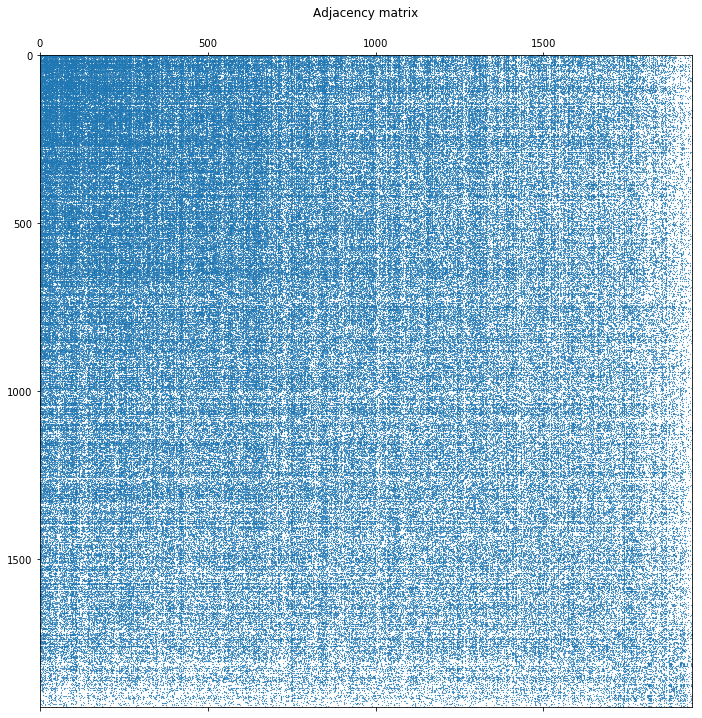

In [19]:
plt.figure(figsize=(12,12))
plt.spy(adjacency, markersize=0.2)
plt.title('Adjacency matrix')

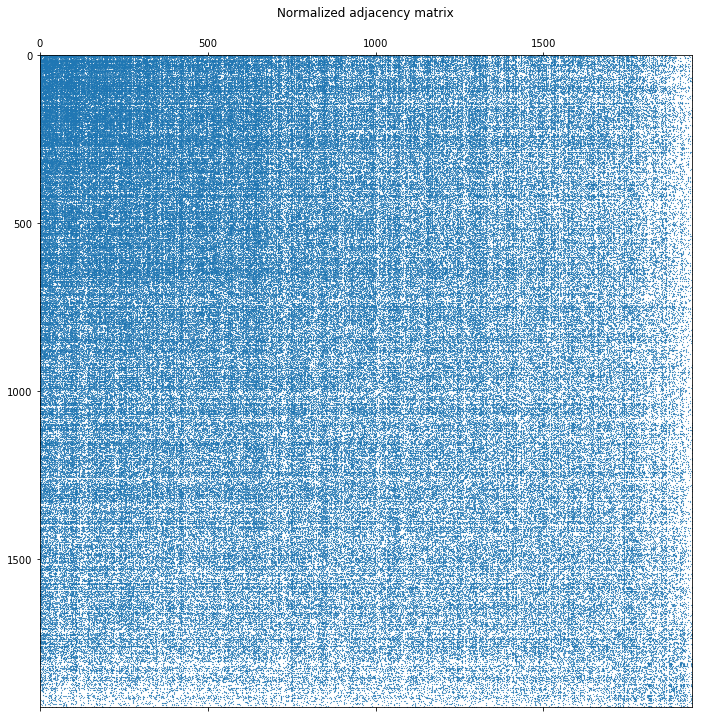

In [20]:
plt.figure(figsize=(12,12))
plt.spy(adjacency_normalized, markersize=0.2)
plt.title('Normalized adjacency matrix')

The maximum number of links in a network with $N$ nodes is $N x (N - 1)$ for a directed graph and $N x (N - 1)/2$ for an undirected one.

Our graph is undirected and weighted; hence the number of links is the s=number of non-zero elements of the adjacency matrix divided by 2.

In [21]:
print(np.count_nonzero(adjacency)/2)

209095.0


In [22]:
n_nodes*(n_nodes -1)/2

1886653.0



A sparse network is a network with fewer links than the maximum possible number of links within the same network. Hence, since a dense network would have around 1 886 653 non-zero elements in the adjacency matrix of this size, and our network has only 209 095, we can conclude that our network is quite sparse.

Undirected graphs have edges that do not have a direction and those edges indicate a two-way relationship, in that each edge can be traversed in both directions. Directed graphs have edges with direction and those edges indicate a one-way relationship, in that each edge can only be traversed in a single direction.

Our graph is undirected since the edges are created based on the number of shared cast and crew members, and those indicate a relationship that goes both and has the same weight in both directions ways (the edge properties are the same regardless of whether we go from Movie1 to Movie2 or vice versa).

In [23]:
features.to_csv('data/final_project_movies_features.csv')
np.save('data/final_project_adjacency', adjacency)
np.save('data/final_project_adjacency_normalized', adjacency_normalized)

In [24]:
adjacency = np.load('data/final_project_adjacency.npy')
adjacency_normalized = np.load('data/final_project_adjacency_normalized.npy')
n_nodes = len(adjacency)
adjacency[:5,:5]

array([[ 0,  1,  0,  2,  5],
       [ 1,  0,  1,  2,  1],
       [ 0,  1,  0,  4,  2],
       [ 2,  2,  4,  0, 10],
       [ 5,  1,  2, 10,  0]])

The graph is unweighted if the edge weights are binary – the edge either exists or no.

In the case of our graph, this is not true, as the edges can have values between 0 and 1 depending on the number of shared employees working on both movies, hence the edges are weighted.

The degree distribution is the probability distribution of the degrees of nodes over the whole graph. To obtain it we had to sum the values of all of the connected edges (since this is an undirected graph) for each of the nodes

In [25]:
# Degreee of each node
degree = np.count_nonzero(adjacency, axis = 0)
assert len(degree) == n_nodes

The cell below to shows the histogram of the degree distribution.

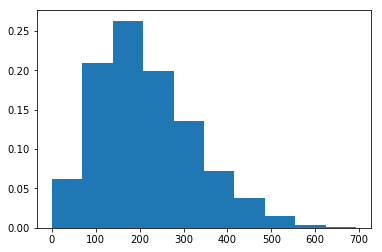

In [26]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

In [27]:
# The average degree of a graph is the sum of the degrees of all nodes, divided by the number of nodes in the graph
np.sum(degree) / n_nodes

215.22902727740606

In [28]:
degree

array([453, 379, 409, ...,   0, 138,  15], dtype=int64)

In [29]:
len(degree)

1943

In [30]:
np.count_nonzero(degree)

1942

As can be seen above, the nodes in our graph tend to have a high degree.
This distribution is most probably due to the high level of collaboration in English-language films in the last 30 years, and the market dominance of certain production companies and their employees. The average degree in our graph is slightly over 215,  when considering the entire cast and crew.

In [31]:
graph = nx.Graph(adjacency)

In [32]:
if nx.is_connected(graph):
    print("The graph is connected.")
else:
    print("The graph is not connected")

The graph is not connected


In [33]:
connected = list(nx.connected_component_subgraphs(graph))
print('The number of connected components in our graph is: ', len(connected))

The number of connected components in our graph is:  2


In [34]:
largest_component = max(connected,key=len)
print('The size of the largest connected component in our graph is: ', len(largest_component.nodes()))

The size of the largest connected component in our graph is:  1942


**It is important  to note that the only unconnected node in our graph is for the film ['Super Size Me'](https://en.wikipedia.org/wiki/Super_Size_Me)**, an independent documentary about the effect of fast food on the human body.

In [35]:
adjacency_largest = nx.to_numpy_matrix(largest_component)
print(len(adjacency_largest))
adjacency_largest[:5,:5]

1942


matrix([[ 0.,  1.,  0.,  2.,  5.],
        [ 1.,  0.,  1.,  2.,  1.],
        [ 0.,  1.,  0.,  4.,  2.],
        [ 2.,  2.,  4.,  0., 10.],
        [ 5.,  1.,  2., 10.,  0.]])

In [36]:
np.save('data/final_project_adjacency_largest', adjacency_largest)

In [37]:
adjacency_largest_normalized = adjacency_normalized.copy()
print(adjacency_largest_normalized.shape)
adjacency_largest_normalized = np.delete(adjacency_largest_normalized, 1940, axis=0)
print(adjacency_largest_normalized.shape)
adjacency_largest_normalized = np.delete(adjacency_largest_normalized, 1940, axis=1)
print(adjacency_largest_normalized.shape)

(1943, 1943)
(1942, 1943)
(1942, 1942)


In [38]:
np.count_nonzero(np.count_nonzero(adjacency_largest_normalized, axis = 0))
np.save('data/final_project_adjacency_largest_normalized', adjacency_largest_normalized)

The diameter of the graph is the length of the longest shortest path between any pair of nodes. 

In [39]:
print("The diametar of the graph is: ", (nx.diameter(largest_component)))

The diametar of the graph is:  4


### Additional dataframe creation

The code below creates a dataframe utilized in other notebooks, specifically those pertaining to the data exploration component of our project.

In [40]:
# We read 'tmdb_5000_credits.csv' and clean the data
credits = pd.read_csv('data/tmdb_5000_credits.csv')
credits = credits[(credits['cast'] != '[]') & (credits['crew'] != '[]')] 

# We read 'tmdb_5000_movies.csv' and clean the data
movies = pd.read_csv('data/tmdb_5000_movies.csv')
movies = movies[(movies['genres'] != '[]') & (movies['keywords'] != '[]')\
               & (movies['production_companies'] != '[]')] 

# JSON parsing

# We only need the 'name' to map cast and crew with specific movie title
credits.cast = credits.cast.apply(lambda x: set(pd.read_json(x, dtype=False).name))
credits.crew = credits.crew.apply(lambda x: set(pd.read_json(x, dtype=False).name))
movies.keywords = movies.keywords.apply(lambda x: set(pd.read_json(x, dtype=False).name))
movies.production_companies = movies.production_companies.apply(lambda x: set(pd.read_json(x, dtype=False).name))

credits = credits.reset_index(drop=True)
movies = movies.reset_index(drop=True)
imdb_data = credits.merge(movies, left_on='movie_id', right_on='id',).rename(columns={'title_x':'title'})
imdb_data = imdb_data.reset_index(drop=True)
relevant_columns = ['movie_id', 'title', 'cast', 'crew', 'budget', 'genres','keywords', 'original_language',
       'popularity', 'production_companies', 
       'release_date', 'revenue', 'runtime', 'status',
       'vote_average', 'vote_count']
imdb_data = imdb_data[relevant_columns]
imdb_data = imdb_data[imdb_data['original_language'] == 'en']
imdb_data = imdb_data[imdb_data['status'] == 'Released']
imdb_data['release_date'] = pd.to_datetime(imdb_data['release_date'], format = '%Y-%m-%d')
imdb_data = imdb_data[imdb_data['release_date'] >= '1990-01-01']
imdb_data = imdb_data[imdb_data['vote_count'] > 225]
imdb_data = imdb_data[imdb_data['revenue'] > 10000]
imdb_data = imdb_data[imdb_data['budget'] > 10000]

imdb_data.drop(columns = 'original_language', inplace = True)
imdb_data = imdb_data.reset_index(drop=True)
imdb_data.drop(imdb_data.index[1940], inplace = True)
print(len(imdb_data))
imdb_data.to_csv('data/refined_imdb_data_project_df.csv')


1942
